In [2]:
import numpy as np
import albumentations as albu
import json
import cv2
from datetime import datetime

import sys
sys.path.append('../preprocess/data_loader')
import matplotlib.pyplot as plt
from data_loader import DataLoader
import torch
from datasets import Dataset, DatasetDict, Features, Value, Image, Sequence, ClassLabel
from PIL import ImageDraw
from PIL import Image as ImagePil
from transformers import AutoModelForImageClassification
from transformers import AutoImageProcessor
from transformers import TrainingArguments, Trainer, DefaultDataCollator

# For evaluate
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, RandomAffine
from transformers import pipeline
import evaluate
from tqdm import tqdm
import torchvision
import os

In [3]:
#CBIS = "/workspace/data/Mammographies/CBIS-DDSM"
#MIAS = "/workspace/data/Mammographies/MIAS"
#INBREAST = "/workspace/data/Mammographies/INBreast"

#loader = DataLoader(INBREAST, MIAS, CBIS)
loader = DataLoader()

features = Features({
    'image': Image(decode=True, id=None),
    'label': ClassLabel(names=["B","M"], id=None)
})


dataset = Dataset.from_generator(loader.classification_generator(target_library="hugging_face",
                                                                 output_size=(400,400)),
                                 features=features,
                                 cache_dir="./dataset_class_cache",
                                 )


Found cached dataset generator (/tf/code/vit-classification/dataset_class_cache/generator/default-5f3415063c9dba49/0.0.0)


In [4]:
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=400x400>,
 'label': 0}

In [5]:
dataset=dataset.shuffle()

In [6]:
# 90% train, 10% test + validation
train_testvalid = dataset.train_test_split(test_size=0.99)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.99)
# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 108
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10663
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 107
    })
})

In [7]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['B', 'M'], id=None)}

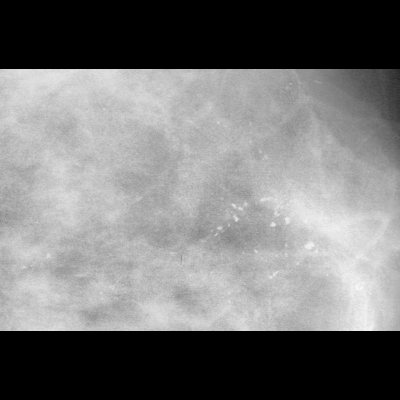

In [8]:
dataset["train"][0]["image"]

In [9]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    
id2label[dataset["train"][0]["label"]], dataset["train"][0]["label"]

('M', 1)

In [10]:
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [11]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size),
                       RandomAffine(degrees=90,translate=(0.25,0.25),scale=(0.8,1)),
                       ToTensor(),
                       normalize])

In [12]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [13]:
ds = dataset.with_transform(transforms)

# Search Hyperparameters

In [14]:
data_collator = DefaultDataCollator()

In [15]:
accuracy = evaluate.load("accuracy")

In [16]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [17]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True),
        "gradient_accumulation_steps": trial.suggest_categorical("gradient_accumulation_steps",
                                                                [1, 2, 4, 8]),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size",
                                                                [1,2,4,8]),
        "warmup_ratio": trial.suggest_float("warmup_ratio",0.1,0.5,step=0.05),
    }

def model_init(trial):     
    return AutoModelForImageClassification.from_pretrained(
        checkpoint,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id,
    )

In [18]:
training_args = TrainingArguments(
    output_dir="hyper_params",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=None,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["valid"],
    tokenizer=image_processor,
    model_init=model_init,
    compute_metrics=compute_metrics,
)

trainer.train()

best_trial = trainer.hyperparameter_search(
    direction="maximize", #default metric is loss
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=10,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkp

Epoch,Training Loss,Validation Loss,Accuracy
1,0.604200,0.593433,0.710280


[I 2023-05-27 23:24:09,472] A new study created in memory with name: no-name-70754094-48e6-4c19-a27e-50d9f9d7c9f8
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN thi

Epoch,Training Loss,Validation Loss,Accuracy
1,0.736000,0.613500,0.710280


[I 2023-05-27 23:24:21,624] Trial 0 finished with value: 0.7102803738317757 and parameters: {'learning_rate': 7.670644609610572e-06, 'weight_decay': 4.0329670011139824e-05, 'gradient_accumulation_steps': 2, 'per_device_train_batch_size': 1, 'warmup_ratio': 0.4}. Best is trial 0 with value: 0.7102803738317757.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImag

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.694625,0.457944


[I 2023-05-27 23:24:28,324] Trial 1 finished with value: 0.45794392523364486 and parameters: {'learning_rate': 1.540066750669641e-06, 'weight_decay': 3.0830089082018345e-06, 'gradient_accumulation_steps': 8, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.25}. Best is trial 0 with value: 0.7102803738317757.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForIm

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.613305,0.710280


[I 2023-05-27 23:24:37,361] Trial 2 finished with value: 0.7102803738317757 and parameters: {'learning_rate': 3.0706147699624944e-05, 'weight_decay': 1.628908403674015e-05, 'gradient_accumulation_steps': 4, 'per_device_train_batch_size': 4, 'warmup_ratio': 0.4}. Best is trial 0 with value: 0.7102803738317757.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImag

Epoch,Training Loss,Validation Loss,Accuracy
1,0.691600,0.680666,0.672897


[I 2023-05-27 23:24:46,358] Trial 3 finished with value: 0.6728971962616822 and parameters: {'learning_rate': 1.2787726716448358e-06, 'weight_decay': 7.367487739472977e-05, 'gradient_accumulation_steps': 1, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.4}. Best is trial 0 with value: 0.7102803738317757.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImag

Epoch,Training Loss,Validation Loss,Accuracy
1,0.956800,0.595040,0.710280


[I 2023-05-27 23:24:57,379] Trial 4 finished with value: 0.7102803738317757 and parameters: {'learning_rate': 4.802754566801389e-05, 'weight_decay': 6.066110175546886e-06, 'gradient_accumulation_steps': 1, 'per_device_train_batch_size': 2, 'warmup_ratio': 0.2}. Best is trial 0 with value: 0.7102803738317757.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImage

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.651062,0.710280


[I 2023-05-27 23:25:05,559] Trial 5 finished with value: 0.7102803738317757 and parameters: {'learning_rate': 1.958922933289827e-05, 'weight_decay': 1.8689309417818546e-05, 'gradient_accumulation_steps': 4, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.2}. Best is trial 0 with value: 0.7102803738317757.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImag

Epoch,Training Loss,Validation Loss,Accuracy
0,0.691300,0.678780,0.682243


[I 2023-05-27 23:25:15,533] Trial 6 finished with value: 0.6822429906542056 and parameters: {'learning_rate': 1.3726493662318098e-06, 'weight_decay': 9.762798200884735e-06, 'gradient_accumulation_steps': 4, 'per_device_train_batch_size': 2, 'warmup_ratio': 0.4}. Best is trial 0 with value: 0.7102803738317757.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImag

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.605691,0.710280


[I 2023-05-27 23:25:23,701] Trial 7 finished with value: 0.7102803738317757 and parameters: {'learning_rate': 6.296124640503161e-05, 'weight_decay': 1.803363616601628e-05, 'gradient_accumulation_steps': 4, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.15000000000000002}. Best is trial 0 with value: 0.7102803738317757.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weight

Epoch,Training Loss,Validation Loss,Accuracy
1,0.574900,0.596581,0.710280


[I 2023-05-27 23:25:34,972] Trial 8 finished with value: 0.7102803738317757 and parameters: {'learning_rate': 2.0297069941979907e-05, 'weight_decay': 2.4364592879473007e-05, 'gradient_accumulation_steps': 4, 'per_device_train_batch_size': 1, 'warmup_ratio': 0.45000000000000007}. Best is trial 0 with value: 0.7102803738317757.
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.638683,0.719626


[I 2023-05-27 23:25:43,835] Trial 9 finished with value: 0.719626168224299 and parameters: {'learning_rate': 1.3987046711934422e-05, 'weight_decay': 8.352297244089028e-06, 'gradient_accumulation_steps': 2, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.30000000000000004}. Best is trial 9 with value: 0.719626168224299.


In [19]:
"""Parameters:
        run_id (:obj:`str`):
            The id of the best run (if models were saved, the corresponding checkpoint will be in the folder ending
            with run-{run_id}).
        objective (:obj:`float`):
            The objective that was obtained for this run.
        hyperparameters (:obj:`Dict[str, Any]`):
            The hyperparameters picked to get this run.
"""
best_trial

BestRun(run_id='9', objective=0.719626168224299, hyperparameters={'learning_rate': 1.3987046711934422e-05, 'weight_decay': 8.352297244089028e-06, 'gradient_accumulation_steps': 2, 'per_device_train_batch_size': 8, 'warmup_ratio': 0.30000000000000004}, run_summary=None)

# Training

In [20]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

training_args = TrainingArguments(
    output_dir=f'/workspace/test_vit_class_{checkpoint.replace("/","_")}_{datetime.now().strftime("%d%m%Y_%H%M%S")}',
    num_train_epochs=10,
    learning_rate=best_trial.hyperparameters["learning_rate"],
    weight_decay=best_trial.hyperparameters["weight_decay"],
    warmup_ratio=best_trial.hyperparameters["warmup_ratio"],
    gradient_accumulation_steps=best_trial.hyperparameters["gradient_accumulation_steps"],
    per_device_train_batch_size=best_trial.hyperparameters["per_device_train_batch_size"],
    per_device_eval_batch_size=8,
    metric_for_best_model="accuracy",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    remove_unused_columns=False,
    logging_steps=10,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["valid"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.8/dist-pa

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.699007,0.514019
2,0.701400,0.658022,0.700935
3,0.662600,0.623147,0.719626
4,0.662600,0.599767,0.710280
5,0.645200,0.589150,0.719626
6,0.596700,0.583369,0.719626
7,0.596700,0.582168,0.710280
8,0.597500,0.582109,0.719626
9,0.590500,0.572789,0.747664
10,0.614200,0.570119,0.728972


TrainOutput(global_step=70, training_loss=0.6297310761043003, metrics={'train_runtime': 79.6319, 'train_samples_per_second': 13.562, 'train_steps_per_second': 0.879, 'total_flos': 8.369134878375936e+16, 'train_loss': 0.6297310761043003, 'epoch': 10.0})

In [21]:
model_name=f'./vit_class_{checkpoint.replace("/","_")}_{datetime.now().strftime("%d%m%Y_%H%M%S")}'
model.save_pretrained(model_name)

# Inference

In [25]:
transform = albu.Compose([
                albu.CLAHE(clip_limit=(1, 10), p=1),
            ])

In [28]:
if 'model_name' not in globals():
    model = AutoModelForImageClassification.from_pretrained(
        "./vit_class_google_vit-base-patch16-224-in21k_27052023_232704",
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id,
    )

model_cpu = model.to("cpu")

test_sample = dataset["test"][5]["image"]

processed_sample = transform(image=np.array(test_sample.convert("RGB")))

image = ImagePil.fromarray(processed_sample["image"])

inputs = image_processor(images=image, return_tensors="pt")
with torch.no_grad():
    logits = model_cpu(**inputs).logits
predicted_label = logits.argmax(-1).item()
id2label[predicted_label]

'B'

In [37]:
model_cpu = model.to("cpu")

test_sample = dataset["test"][5]["image"]

processed_sample = transform(image=np.array(test_sample.convert("RGB")))

image = ImagePil.fromarray(processed_sample["image"])

classifier = pipeline("image-classification", model=model, image_processor=image_processor)
results=classifier(image)
results

[{'score': 0.6404788494110107, 'label': 'B'},
 {'score': 0.35952118039131165, 'label': 'M'}]

In [43]:
max(results, key=lambda x: x["score"])

{'score': 0.6404788494110107, 'label': 'B'}

# Evaluate

In [ ]:
metrics = trainer.evaluate(ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)